In [19]:
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [20]:
# path
path= "./_効果検証入門/input/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
data= pd.read_csv(path) 
data.head(1)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0


In [21]:
male_df = data[  data["segment"] != 'Womens E-Mail']  ##28818rows
male_df["treatment"]  = male_df["segment"].apply(lambda x: 1 if x in ["Mens E-Mail"] else 0)
male_df["history_log"] = male_df["history"].apply(lambda x: np.log(x))
male_df.head(1)

<ipython-input-21-7a9284bad027>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df["treatment"]  = male_df["segment"].apply(lambda x: 1 if x in ["Mens E-Mail"] else 0)
<ipython-input-21-7a9284bad027>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df["history_log"] = male_df["history"].apply(lambda x: np.log(x))


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,5.796301


In [22]:
# threshold_value
threshold_value = 5.5

In [23]:


male_df["history_log_grp"] = male_df["history_log"].apply(lambda x: round(x/0.1,0)*0.1)

rdd_data = male_df[  ((male_df["history_log"] > threshold_value)  & (male_df["segment"] == "Mens E-Mail"))|
                       ((male_df["history_log"] <= threshold_value) &(male_df["segment"] == "No E-Mail"))
                    ]

<ipython-input-23-3b1b066cf539>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df["history_log_grp"] = male_df["history_log"].apply(lambda x: round(x/0.1,0)*0.1)


In [24]:
male_df.head(2)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,5.796301,5.8
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942,6.5


In [25]:
# (4) RCTデータとRDDデータの傾向の比較
## running variableとサイト来訪率のプロット(RCTデータ)

# check your code
# male_df.groupby(["history_log_grp", "segment"]).agg({"visit":"mean"},{"n":"count"})

male_data_groupby = male_df.groupby(['history_log_grp', 'segment'])['visit'].agg(['mean', 'count']).reset_index()
male_data_groupby = male_data_groupby.loc[male_data_groupby['count'] > 10]
male_data_groupby.head()

,history_log_grp,segment,mean,count
0,3.4,Mens E-Mail,0.146545,2750
1,3.4,No E-Mail,0.086988,2805
2,3.5,Mens E-Mail,0.169118,272
3,3.5,No E-Mail,0.084942,259
4,3.6,Mens E-Mail,0.158576,309


<Axes: >

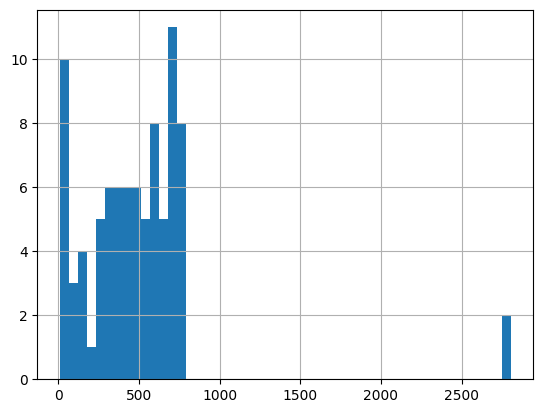

In [26]:
male_data_groupby["count"].hist(bins=50)

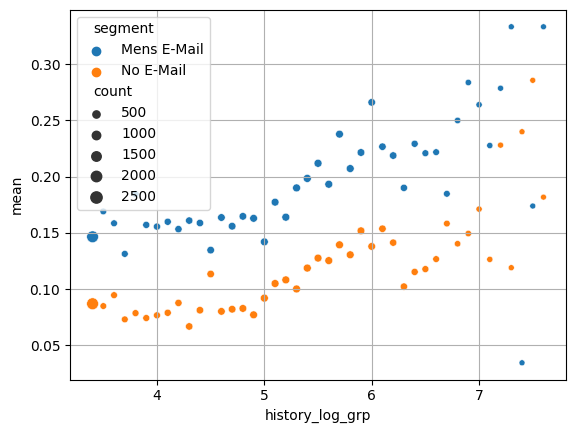

In [27]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(
    data=male_data_groupby,
    x='history_log_grp',
    y='mean',
    hue='segment',
    size='count'
)

plt.grid()

In [28]:
## running variableとサイト来訪率のプロット(RDDデータ)
rdd_data_groupby = rdd_data.groupby(['history_log_grp', 'segment'])['visit'].agg(['mean', 'count']).reset_index()
rdd_data_groupby = rdd_data_groupby.loc[rdd_data_groupby['count'] > 10]
rdd_data_groupby.head()


,history_log_grp,segment,mean,count
0,3.4,No E-Mail,0.086988,2805
1,3.5,No E-Mail,0.084942,259
2,3.6,No E-Mail,0.094637,317
3,3.7,No E-Mail,0.073090,301
4,3.8,No E-Mail,0.078652,356


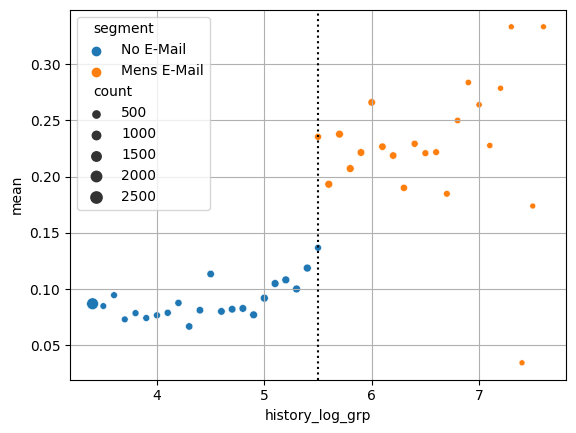

In [29]:
sns.scatterplot(
    data=rdd_data_groupby,
    x='history_log_grp',
    y='mean',
    hue='segment',
    size='count'
)

plt.grid()
plt.axvline([5.5], color='black', ls=':')

In [30]:
# 集計による比較
rdd_data.groupby(['treatment'])['visit'].agg(['mean', 'count'])

,mean,count
treatment,,
0,0.090694,13926
1,0.224002,7366


In [33]:
# 線形回帰による分析
rdd_lm_reg = smf.ols(
    data=rdd_data,
    formula='visit ~ treatment + history_log'
).fit()

rdd_lm_reg.summary().tables[1]

#	history       0.1199 (treatment)
# history_log   0.1137 (treatment)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0404,0.016,2.454,0.014,0.008,0.073
treatment,0.1137,0.008,14.240,0.000,0.098,0.129
history_log,0.0114,0.004,3.103,0.002,0.004,0.019


In [36]:
for i in range(4):
  print(i)

0
1
2
3


# 非線形回帰による分析

In [ ]:
#memo
"""
まず、この式であってるのか？
次に、あっていたとして、もっと自動化できないか？ smf.ols(   foumula=　　　　　の形の問題。
    foumulaは、strなの？
    ''' '''でfを利用することができるのか？

"""

power=1    effect=0.1136
power=2    effect=0.0992
power=3    effect=0.0860
power=4    effect=0.0741
power=5    effect=0.0593
power=6    effect=0.0940
power=7    effect=0.0993
power=8    effect=0.0869
power=9    effect=0.0683
power=10   effect=0.0859




In [56]:
rdd_data.columns

Index(['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel', 'segment', 'visit', 'conversion', 'spend',
       'treatment', 'history_log', 'history_log_grp', 'history_log_1',
       'treatment_history_log_1', 'history_log_2', 'treatment_history_log_2',
       'history_log_3', 'treatment_history_log_3', 'history_log_4',
       'treatment_history_log_4', 'history_log_5', 'treatment_history_log_5',
       'history_log_6', 'treatment_history_log_6'],
      dtype='object')

## power =1~5

In [54]:
# 非線形回帰による分析
power = 1   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 +    
              treatment_history_log_1  
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-54-865b4ddcecf4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-54-865b4ddcecf4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1032,0.005,19.480,0.000,0.093,0.114
treatment,0.1136,0.009,13.288,0.000,0.097,0.130
history_log_1,0.0114,0.004,2.805,0.005,0.003,0.019
treatment_history_log_1,0.0003,0.010,0.026,0.979,-0.019,0.019


In [53]:
# 非線形回帰による分析
power = 2   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2   +  
              treatment_history_log_1 + treatment_history_log_2 
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-53-e8cd105c8c60>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-53-e8cd105c8c60>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1211,0.008,14.955,0.000,0.105,0.137
treatment,0.0992,0.012,8.070,0.000,0.075,0.123
history_log_1,0.0612,0.018,3.492,0.000,0.027,0.096
history_log_2,0.0216,0.007,2.922,0.003,0.007,0.036
treatment_history_log_1,-0.0634,0.032,-1.989,0.047,-0.126,-0.001
treatment_history_log_2,-0.0129,0.017,-0.741,0.459,-0.047,0.021


In [52]:
# 非線形回帰による分析
power = 3   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3  +  
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-52-4d0e3a25c65a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-52-4d0e3a25c65a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1263,0.011,11.558,0.000,0.105,0.148
treatment,0.0860,0.016,5.384,0.000,0.055,0.117
history_log_1,0.0910,0.045,2.007,0.045,0.002,0.180
history_log_2,0.0564,0.049,1.142,0.253,-0.040,0.153
history_log_3,0.0105,0.015,0.713,0.476,-0.018,0.039
treatment_history_log_1,-0.0377,0.072,-0.524,0.600,-0.179,0.103
treatment_history_log_2,-0.1256,0.086,-1.454,0.146,-0.295,0.044
treatment_history_log_3,0.0176,0.029,0.607,0.544,-0.039,0.074


In [ ]:
# 非線形回帰による分析
power = 4   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

In [48]:
# 非線形回帰による分析
power = 5   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  history_log_5 +
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4 +treatment_history_log_5
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-48-6272e7a39200>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-48-6272e7a39200>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1331,0.017,8.002,0.000,0.101,0.166
treatment,0.0593,0.023,2.535,0.011,0.013,0.105
history_log_1,0.1580,0.162,0.973,0.331,-0.160,0.476
history_log_2,0.2075,0.484,0.429,0.668,-0.742,1.157
history_log_3,0.1319,0.587,0.225,0.822,-1.018,1.282
history_log_4,0.0358,0.307,0.117,0.907,-0.565,0.637
history_log_5,0.0025,0.057,0.044,0.965,-0.110,0.115
treatment_history_log_1,0.1694,0.230,0.738,0.461,-0.281,0.619
treatment_history_log_2,-1.1544,0.686,-1.683,0.092,-2.499,0.190
treatment_history_log_3,0.9531,0.828,1.151,0.250,-0.670,2.576


## power= 6, 7

In [47]:
# 非線形回帰による分析
power = 6   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  history_log_5 + history_log_6+
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4 +treatment_history_log_5 +treatment_history_log_6
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-47-08f33920f1c7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-47-08f33920f1c7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1253,0.020,6.424,0.000,0.087,0.164
treatment,0.0940,0.027,3.459,0.001,0.041,0.147
history_log_1,0.0025,0.260,0.009,0.992,-0.508,0.513
history_log_2,-0.5406,1.091,-0.495,0.620,-2.680,1.599
history_log_3,-1.3055,1.969,-0.663,0.507,-5.165,2.554
history_log_4,-1.2539,1.714,-0.732,0.464,-4.614,2.106
history_log_5,-0.5381,0.709,-0.759,0.448,-1.928,0.852
history_log_6,-0.0855,0.112,-0.765,0.444,-0.305,0.134
treatment_history_log_1,-0.2195,0.361,-0.609,0.543,-0.926,0.487
treatment_history_log_2,2.1819,1.496,1.458,0.145,-0.750,5.114


In [ ]:
# 非線形回帰による分析
power = 7   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  history_log_5 + history_log_6+ history_log_7 +
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4 +treatment_history_log_5 +treatment_history_log_6 +treatment_history_log_7
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

## power = 8,9,10

In [ ]:
# 非線形回帰による分析
power = 8   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  history_log_5 + history_log_6+ history_log_7 + history_log_8+ 
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4 +treatment_history_log_5 +treatment_history_log_6 +treatment_history_log_7 +treatment_history_log_8
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

In [61]:
# 非線形回帰による分析
power = 9   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  history_log_5 + history_log_6+ history_log_7 + history_log_8+ history_log_9+
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4 +treatment_history_log_5 +treatment_history_log_6 +treatment_history_log_7 +treatment_history_log_8+treatment_history_log_9
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-61-10c0d29a4cc6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-61-10c0d29a4cc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1431,0.028,5.073,0.000,0.088,0.198
treatment,0.0683,0.039,1.763,0.078,-0.008,0.144
history_log_1,0.6519,0.770,0.846,0.397,-0.858,2.162
history_log_2,5.5250,6.890,0.802,0.423,-7.980,19.030
history_log_3,23.2631,28.371,0.820,0.412,-32.347,78.873
history_log_4,51.5391,63.281,0.814,0.415,-72.496,175.575
history_log_5,65.3921,82.631,0.791,0.429,-96.571,227.355
history_log_6,49.3804,64.926,0.761,0.447,-77.879,176.640
history_log_7,21.9751,30.177,0.728,0.466,-37.173,81.124
history_log_8,5.3259,7.636,0.698,0.485,-9.640,20.292


In [62]:


# 非線形回帰による分析
power = 10   #冪乗
for i in range(power):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']
      # history_log_1
      # treatment_history_log_1

nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula=''' visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 +  history_log_5 + history_log_6+ history_log_7 + history_log_8+ history_log_9+history_log_10+
              treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4 +treatment_history_log_5 +treatment_history_log_6 +treatment_history_log_7 +treatment_history_log_8+treatment_history_log_9+treatment_history_log_10
    '''
).fit()
nonlinear_rdd_ord4.summary().tables[1]

<ipython-input-62-f99fef3283cc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
<ipython-input-62-f99fef3283cc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1320,0.031,4.246,0.000,0.071,0.193
treatment,0.0859,0.043,2.016,0.044,0.002,0.169
history_log_1,0.0784,1.027,0.076,0.939,-1.935,2.092
history_log_2,-1.9180,11.190,-0.171,0.864,-23.852,20.016
history_log_3,-18.2236,56.750,-0.321,0.748,-129.457,93.010
history_log_4,-71.0423,158.409,-0.448,0.654,-381.535,239.451
history_log_5,-147.2705,265.142,-0.555,0.579,-666.968,372.427
history_log_6,-178.0411,277.134,-0.642,0.521,-721.244,365.162
history_log_7,-129.6757,182.174,-0.712,0.477,-486.750,227.399
history_log_8,-56.0668,73.130,-0.767,0.443,-199.407,87.274


# 